Judul Proyek: Deteksi Deepfake Menggunakan Transfer Learning (MobileNetV2)

Deskripsi Masalah: Meningkatnya penyalahgunaan teknologi Deepfake menuntut adanya sistem deteksi otomatis. Masalah ini adalah masalah Klasifikasi Biner (Binary Classification) pada citra digital.

Unsur Masalah:

Input: Citra Wajah (Image).  
Output: Label (Real vs Fake).  
Metode: Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2.

Tim:
- Divay Imam Syuhada (231401100)
- Gerti Armanda Sembiring (231401133)
- Kevin Swandana (231401136)

Library

In [ ]:
import zipfile
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Data Loading

In [ ]:
repo_url = "https://github.com/Garmandsk/aplikasi-deteksi-deepfake"
repo_name = "aplikasi-deteksi-deepfake"

if not os.path.exists(repo_name):
    print(f"Sedang meng-clone repository {repo_name}...")
    !git clone $repo_url
else:
    print("Repository sudah ada. Melakukan pull update terbaru...")
    %cd $repo_name
    !git pull
    %cd ..

print("✅ Berhasil! File model dan script sudah siap.")

# Download Dataset dari Kaggle (Otomatis)

# Cek apakah dataset sudah ada
if not os.path.exists('/content/rvf10k'):
    print("Dataset belum ditemukan. Silakan upload file kaggle.json Anda.")
    print("Ambil di Kaggle > Profile Settings > Legacy API Credentials > Create Legacy API Key")     # Minta user upload token kaggle mereka
    # Ambil di Kaggle > Profile Settings > Legacy API Credentials > Create Legacy API Key
    from google.colab import files
    files.upload() # User akan diminta upload kaggle.json

    # Setup Kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("Sedang mendownload dataset...")
    !kaggle datasets download -d sachchitkunichetty/rvf10k --unzip

    print("✅ Dataset berhasil didownload dan diekstrak!")
else:
    print("✅ Dataset sudah siap.")

# Penyesuaian direktori
dataset_dir = '/content/rvf10k' # Sesuaikan nama folder hasil unzip Kaggle
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

train_df = pd.read_csv('/content/train.csv')
valid_df = pd.read_csv('/content/valid.csv')

Sedang meng-clone repository aplikasi-deteksi-deepfake...
Cloning into 'aplikasi-deteksi-deepfake'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 53 (delta 19), reused 39 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 27.35 MiB | 43.22 MiB/s, done.
Resolving deltas: 100% (19/19), done.
✅ Berhasil! File model dan script sudah siap.
Dataset belum ditemukan. Silakan upload file kaggle.json Anda.
Ambil di Kaggle > Profile Settings > Legacy API Credentials > Create Legacy API Key


Saving kaggle.json to kaggle.json
Sedang mendownload dataset...
Dataset URL: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k
License(s): CC-BY-NC-SA-4.0
 95% 260M/273M [00:00<00:00, 845MB/s] 
100% 273M/273M [00:00<00:00, 866MB/s]
✅ Dataset berhasil didownload dan diekstrak!


Data Preprocessing

In [ ]:
# Hapus Kolom tidak terpakai
train_df = train_df.iloc[:, 1:] # Mengambil semua baris, dan kolom mulai dari indeks 1 ke belakang
train_df.drop(columns=["original_path", "label_str"], inplace=True)
valid_df = valid_df.iloc[:, 1:] # Mengambil semua baris, dan kolom mulai dari indeks 1 ke belakang
valid_df.drop(columns=["original_path", "label_str"], inplace=True)

# Rapikan daftar kolom
train_df = train_df[['id', 'path', 'label']]
valid_df = valid_df[['id', 'path', 'label']]

# Pastikan kolom label dibaca sebagai String (agar mode 'binary' jalan lancar)
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [ ]:
train_df

,id,path,label
0,28609,train/real/28609.jpg,1
1,30395,train/real/30395.jpg,1
2,22430,train/real/22430.jpg,1
3,58380,train/real/58380.jpg,1
4,62044,train/real/62044.jpg,1
...,...,...,...
6995,BOWRWM6PGW,train/fake/BOWRWM6PGW.jpg,0
6996,KJBNF2E757,train/fake/KJBNF2E757.jpg,0
6997,GWBNI5PQZY,train/fake/GWBNI5PQZY.jpg,0
6998,KE912CBW0Y,train/fake/KE912CBW0Y.jpg,0


In [ ]:
valid_df

,id,path,label
0,24731,valid/real/24731.jpg,1
1,02004,valid/real/02004.jpg,1
2,68164,valid/real/68164.jpg,1
3,39647,valid/real/39647.jpg,1
4,49014,valid/real/49014.jpg,1
...,...,...,...
2995,ADT2KUA64L,valid/fake/ADT2KUA64L.jpg,0
2996,EJTRZA0FJS,valid/fake/EJTRZA0FJS.jpg,0
2997,25F3F4OUKD,valid/fake/25F3F4OUKD.jpg,0
2998,MKZIOSEAD6,valid/fake/MKZIOSEAD6.jpg,0


Exploratory Data Analysis (EDA)

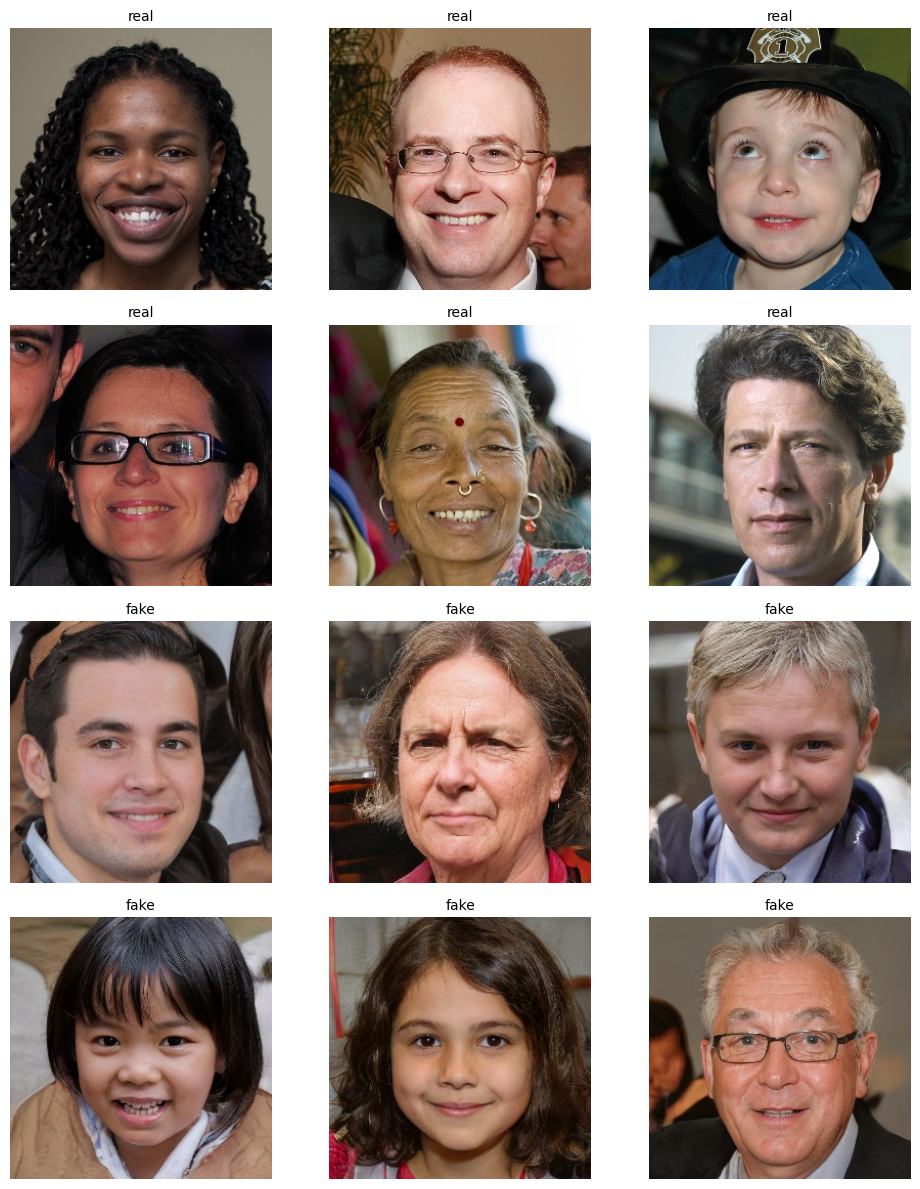

In [ ]:
def show_random_image_on_ax(directory, class_name, ax):
    target_folder = os.path.join(directory, class_name)

    # Cek apakah folder ada isinya
    if not os.path.exists(target_folder):
        print(f"Folder {class_name} tidak ditemukan!")
        return

    all_images = os.listdir(target_folder)
    if len(all_images) == 0:
        print(f"Tidak ada gambar di {class_name}")
        return

    random_image = random.choice(all_images)
    img_path = os.path.join(target_folder, random_image)

    try:
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=10)
        ax.axis('off')
    except Exception as e:
        print(f"Error load gambar: {e}")

plt.figure(figsize=(10, 12))

# Menampilkan 6 Gambar REAL di Baris Atas (Indeks 1-6)
real_folder_name = 'real' # Ubah jadi 'Real' jika error folder not found
for i in range(6):
    ax = plt.subplot(4, 3, i + 1) # Baris 1, Kolom ke-(i+1)
    show_random_image_on_ax(train_dir, real_folder_name, ax)

# Menampilkan 6 Gambar FAKE di Baris Bawah (Indeks 7-12)
fake_folder_name = 'fake' # Ubah jadi 'Fake' jika error folder not found
for i in range(6):
    ax = plt.subplot(4, 3, i + 7) # Lanjut ke indeks 7 sampai 12
    show_random_image_on_ax(train_dir, fake_folder_name, ax)

plt.tight_layout()
plt.show()

Explanatory Data Analysis (ExDA)

Jumlah Real: 3500
Jumlah Fake: 3500


/tmp/ipython-input-1082754229.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Real', 'Fake'], y=[real_count, fake_count], palette='viridis')


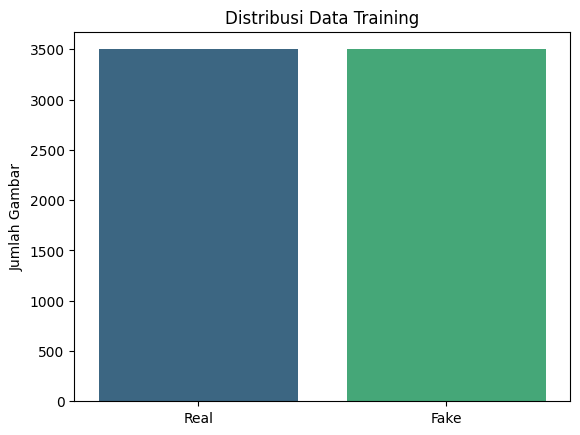

In [ ]:
# Menghitung jumlah file
real_count = len(os.listdir(os.path.join(train_dir, 'real')))
fake_count = len(os.listdir(os.path.join(train_dir, 'fake')))

print(f"Jumlah Real: {real_count}")
print(f"Jumlah Fake: {fake_count}")

# Visualisasi Bar Chart
sns.barplot(x=['Real', 'Fake'], y=[real_count, fake_count], palette='viridis')
plt.title('Distribusi Data Training')
plt.ylabel('Jumlah Gambar')
plt.show()

Data Splitting

In [ ]:
# Augmentasi Data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup Generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_dir, # Folder tempat file gambar berada
    x_col="path", # Ganti dengan nama header kolom nama file di CSV
    y_col="label",    # Ganti dengan nama header kolom label (0/1/Real/Fake)
    target_size=(224, 224), # Sesuaikan input model
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=dataset_dir,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False # Validasi jangan di-shuffle agar urut saat evaluasi
)

Found 7000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Modelling

In [ ]:
# Ambil Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

# Bekukan 100 layer pertama (Biarkan tetap seperti ImageNet untuk Kecepatan Training)
# MobileNetV2 total punya sekitar 155 layer
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Tambah neuron biar lebih pintar
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model Fine-Tuning Siap! Layer 100 ke atas akan dilatih ulang.")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Fine-Tuning Siap! Layer 100 ke atas akan dilatih ulang.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,189,633 (8.35 MB)

 Non-trainable params: 396,544 (1.51 MB)

Training

In [ ]:
best_model_path = '/content/models/model_deepfake_best.keras'

# Setup Callbacks
callbacks = [
    # Stop kalau val_loss gak turun-turun selama 5 epoch
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),

    # Simpan model terbaik saja (bukan yang terakhir)
    ModelCheckpoint(best_model_path,
                    save_best_only=True,
                    monitor='val_accuracy')
]

# Latih Model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 148s 535ms/step - accuracy: 0.6605 - loss: 0.6242 - val_accuracy: 0.5003 - val_loss: 2.1749
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 411ms/step - accuracy: 0.8205 - loss: 0.4018 - val_accuracy: 0.5023 - val_loss: 3.3811
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 411ms/step - accuracy: 0.8683 - loss: 0.3049 - val_accuracy: 0.5430 - val_loss: 2.4184
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 409ms/step - accuracy: 0.8966 - loss: 0.2442 - val_accuracy: 0.6177 - val_loss: 1.8628
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 416ms/step - accuracy: 0.9160 - loss: 0.2067 - val_accuracy: 0.7763 - val_loss: 0.7103
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.9396 - loss: 0.1572 - val_accuracy: 0.7753 - val_loss: 0.8179
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 413ms/step - accuracy: 0.9432 - loss: 0.1396 - val_accuracy: 0.8060 - val_loss: 0.6372
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 414ms/step - accuracy: 0.9593 - loss: 

Evaluate

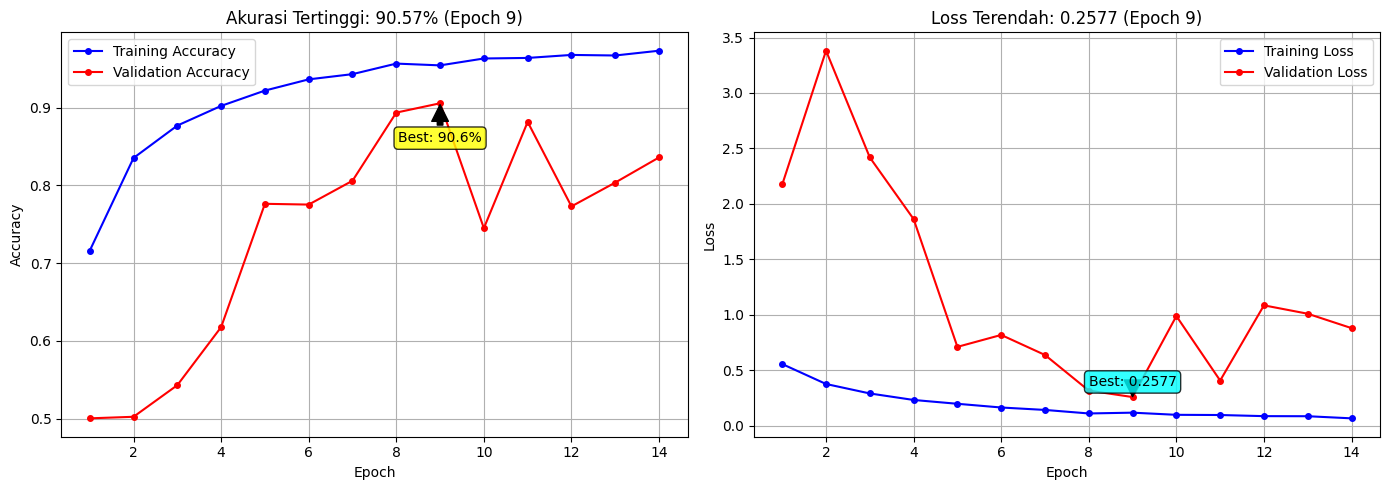

Label Indices: {'0': 0, '1': 1}


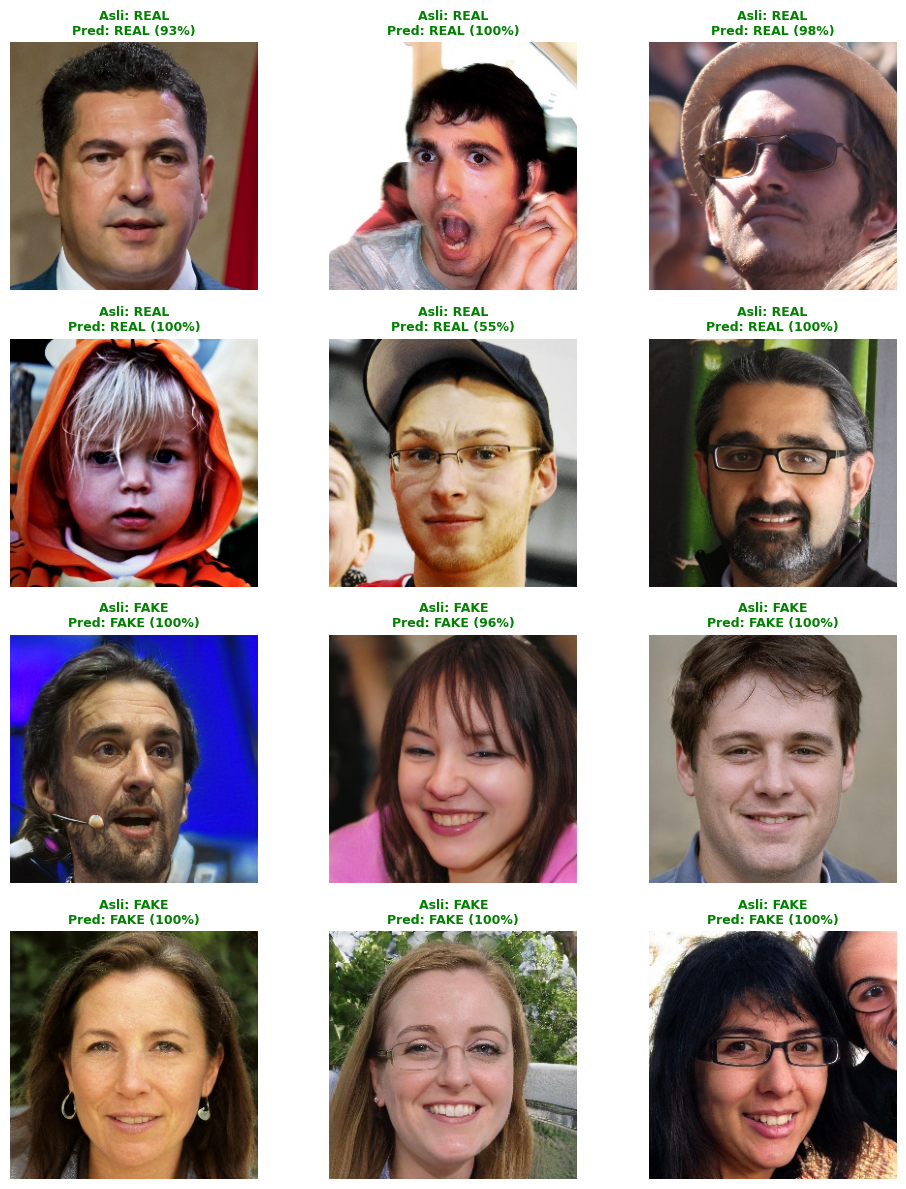

In [16]:
# 1. Grafik Akurasi dan Loss

# Ambil Data dari History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1) # Mulai dari Epoch 1, bukan 0

# Cari Titik Terbaik (Best Epoch)
# Akurasi Terbaik = Nilai Validasi Tertinggi (Max)
best_acc_val = max(val_acc)
best_acc_epoch = val_acc.index(best_acc_val) + 1 # Ditambah 1 karena index mulai dari 0

# Loss Terbaik = Nilai Validasi Terendah (Min)
best_loss_val = min(val_loss)
best_loss_epoch = val_loss.index(best_loss_val) + 1

# Plotting
plt.figure(figsize=(14, 5))

# --- GRAFIK 1: AKURASI ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy', markersize=4) # 'bo-' artinya Blue, Circle, Line
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy', markersize=4) # 'ro-' artinya Red
plt.title(f'Akurasi Tertinggi: {best_acc_val:.2%} (Epoch {best_acc_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Menambahkan Label Panah di Titik Terbaik
plt.annotate(f'Best: {best_acc_val:.1%}',
             xy=(best_acc_epoch, best_acc_val), # Titik yang ditunjuk
             xytext=(best_acc_epoch, best_acc_val - 0.05), # Posisi teks (sedikit di bawah titik)
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8)) # Kotak kuning biar jelas

# --- GRAFIK 2: LOSS (ERROR) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss', markersize=4)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', markersize=4)
plt.title(f'Loss Terendah: {best_loss_val:.4f} (Epoch {best_loss_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Menambahkan Label Panah di Titik Terbaik
plt.annotate(f'Best: {best_loss_val:.4f}',
             xy=(best_loss_epoch, best_loss_val),
             xytext=(best_loss_epoch, best_loss_val + 0.1), # Posisi teks (sedikit di atas titik)
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="black", alpha=0.8)) # Kotak cyan

plt.tight_layout()
plt.show()

# 2. Test Prediksi Sederhana

class_indices = train_generator.class_indices
print("Label Indices:", class_indices)

def test_random_image_on_ax(directory, true_label, ax):
    target_folder = os.path.join(directory, true_label)

    if not os.path.exists(target_folder):
        return

    all_images = os.listdir(target_folder)
    if not all_images:
        return

    random_image = random.choice(all_images)
    img_path = os.path.join(target_folder, random_image)

    # Load & Preprocess Gambar
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 # Normalisasi!

    # Prediksi
    prediction = model.predict(x, verbose=0)
    score = prediction[0][0]

    # Logika Label (Asumsi 0=Fake, 1=Real)
    pred_label = "FAKE" if score < 0.5 else "REAL"
    confidence = (1 - score) if score < 0.5 else score # Seberapa yakin dia?

    # Tampilkan Gambar
    try:
        img_show = mpimg.imread(img_path)
        ax.imshow(img_show)

        # Logika Warna: Hijau jika Benar, Merah jika Salah
        is_correct = (true_label.lower() == pred_label.lower())
        text_color = 'green' if is_correct else 'red'
        title_text = f"Asli: {true_label.upper()}\nPred: {pred_label} ({confidence:.0%})"
        ax.set_title(title_text, fontsize=9, color=text_color, weight='bold')
        ax.axis('off')

    except Exception as e:
        print(f"Error load gambar: {e}")

plt.figure(figsize=(10, 12)) # Ukuran diperbesar biar teks terbaca

# Prediksi 6 Gambar REAL
real_folder = 'real' # Cek apakah di folder namanya 'real' atau 'Real'
for i in range(6):
    ax = plt.subplot(4, 3, i + 1)
    test_random_image_on_ax(valid_dir, real_folder, ax) # Pakai validation_dir

# Prediksi 6 Gambar FAKE
fake_folder = 'fake' # Cek apakah di folder namanya 'fake' atau 'Fake'
for i in range(6):
    ax = plt.subplot(4, 3, i + 7) # Lanjut index ke 7
    test_random_image_on_ax(valid_dir, fake_folder, ax) # Pakai validation_dir

plt.tight_layout()
plt.show()

Deployment

In [ ]:
# Simpan Model Final
final_model_path = '/content/models/model_deepfake_final.keras'

model.save(final_model_path)
print(f"Model berhasil disimpan di: {final_model_path}")

Ori vs Best vs Final Model

In [18]:
best_path = best_model_path
final_path = final_model_path
ori_path = '/content/aplikasi-deteksi-deepfake/app_files/model_deepfake_ori.keras'

# Variabel placeholder untuk hasil
loss_best, acc_best = 0, 0
loss_final, acc_final = 0, 0
loss_ori, acc_ori = 0, 0

# Load Ketiga Model
print("--- MEMUAT MODEL ---")
try:
    model_best = load_model(best_path)
    print("✅ Model BEST berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat Model BEST. Error: {e}")
    model_best = None

try:
    model_final = load_model(final_path)
    print("✅ Model FINAL berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat Model FINAL. Error: {e}")
    model_final = None

try:
    model_ori = load_model(ori_path)
    print("✅ Model ORI berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat Model ORI. Error: {e}")
    model_ori = None


# Evaluasi
print("\n--- MEMULAI EVALUASI (Ini mungkin memakan waktu 1-3 menit) ---")

# Evaluasi Model Best
if model_best:
    print("Menguji Model Best...")
    valid_generator.reset() # Reset agar mulai dari awal
    loss_best, acc_best = model_best.evaluate(valid_generator, verbose=1)

# Evaluasi Model Final
if model_final:
    print("Menguji Model Final...")
    valid_generator.reset()
    loss_final, acc_final = model_final.evaluate(valid_generator, verbose=1)

# Evaluasi Model Ori
if model_ori:
    print("Menguji Model Ori...")
    valid_generator.reset()
    loss_ori, acc_ori = model_ori.evaluate(valid_generator, verbose=1)

# Tampilkan Hasil Perbandingan
print("\n" + "="*65)
print(f"{'METRIK':<15} | {'MODEL BEST':<12} | {'MODEL FINAL':<12} | {'MODEL ORI':<12}")
print("-" * 65)
print(f"{'Akurasi':<15} | {acc_best:.2%}      | {acc_final:.2%}      | {acc_ori:.2%}")
print(f"{'Loss (Error)':<15} | {loss_best:.4f}      | {loss_final:.4f}      | {loss_ori:.4f}")
print("="*65)

# Kesimpulan
winner = ""
file_to_use = ""

if acc_best >= acc_final and acc_best >= acc_ori:
    winner = "MODEL BEST"
    file_to_use = best_path
    runner_up = max(acc_final, acc_ori)
    diff = acc_best - runner_up
elif acc_final >= acc_best and acc_final >= acc_ori:
    winner = "MODEL FINAL"
    file_to_use = final_path
    runner_up = max(acc_best, acc_ori)
    diff = acc_final - runner_up
else:
    winner = "MODEL ORI"
    file_to_use = ori_path
    runner_up = max(acc_best, acc_final)
    diff = acc_ori - runner_up

print(f"\n🏆 PEMENANG: {winner}")
if diff > 0:
    print(f"Selisih Akurasi dengan model kedua terbaik: {diff:.2%}")
else:
    print("Hasil Seri atau selisih sangat tipis.")

print(f"👉 Saran: Gunakan file '{file_to_use}' untuk Demo & Aplikasi.")

--- MEMUAT MODEL ---
✅ Model BEST berhasil dimuat.
✅ Model FINAL berhasil dimuat.
✅ Model ORI berhasil dimuat.

--- MEMULAI EVALUASI (Ini mungkin memakan waktu 1-3 menit) ---
Menguji Model Best...
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8852 - loss: 0.3136
Menguji Model Final...
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8852 - loss: 0.3136
Menguji Model Ori...
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9363 - loss: 0.1901

METRIK          | MODEL BEST   | MODEL FINAL  | MODEL ORI   
-----------------------------------------------------------------
Akurasi         | 90.57%      | 90.57%      | 93.47%
Loss (Error)    | 0.2577      | 0.2577      | 0.2010

🏆 PEMENANG: MODEL ORI
Selisih Akurasi dengan model kedua terbaik: 2.90%
👉 Saran: Gunakan file '/content/aplikasi-deteksi-deepfake/app_files/model_deepfake_ori.keras' untuk Demo & Aplikasi.
